In [14]:
from typing import Tuple
import os
import category_encoders as ce
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import time
import seaborn as sns
from matplotlib import cm

In [2]:
class DataLoader:
    def __init__(self):
        pass

    def load_data(self, file_path: str, output_file_path=None) -> pd.DataFrame:
        '''
        读取csv或文本文件，支持单个文件或文件夹

        file_path: str, 文件路径或文件夹路径
        output_file_path: str, 输出文件路径, 如果不为None, 则将数据转为csv保存到该路径
        '''
        if os.path.isfile(file_path):
            # 如果是文件，直接读取
            df = pd.read_csv(file_path, header=None)
        elif os.path.isdir(file_path):
            # 如果是文件夹，读取所有文件并整合
            all_files = [os.path.join(file_path, f)
                         for f in os.listdir(file_path)]
            df_list = [pd.read_csv(f, header=None) for f in all_files]
            df = pd.concat(df_list, ignore_index=True)
        else:
            raise ValueError(f"{file_path} 不是有效的文件或文件夹路径")

        # 如果不是 CSV 文件，添加列名
        if not file_path.endswith('.csv'):
            df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                          'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                          'hours-per-week', 'native-country', 'income']

        # 如果指定了输出路径，保存为 CSV 文件
        if output_file_path:
            df.to_csv(output_file_path, index=False)

        return df

    def save_data(self, data, file_path: str):
        '''
        保存数据到csv文件
        data: pd.DataFrame 或 numpy.ndarray, 数据
        file_path: str, 文件路径
        '''
        if isinstance(data, np.ndarray):
            data = pd.DataFrame(data)
        data.to_csv(file_path, index=False)
        return data

    def data_noise(self, df: pd.DataFrame, noise_level: float = 0.2) -> pd.DataFrame:
        """
        增加高斯噪音、随机clip和mask
        df: pd.DataFrame, 输入数据
        noise_level: float, 噪声强度
        return: pd.DataFrame, 添加噪声后的数据
        """
        # 增加高斯噪声
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            df[col] += np.random.normal(0, noise_level *
                                        df[col].std(), size=df[col].shape)

        # 随机clip
        for col in numeric_cols:
            lower_bound = df[col].quantile(0.01)
            upper_bound = df[col].quantile(0.99)
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

        # # 随机mask
        # mask_prob = 0.01  # 1% 的概率将值设置为 NaN
        # mask = np.random.rand(*df.shape) < mask_prob
        # df = df.mask(mask)

        return df

    def preprocess_data(self, df: pd.DataFrame,
                        missing_value_method: str = "impute",
                        low_card_method: str = "onehot",
                        high_card_mehtod: str = "target",
                        if_standard: bool = True,
                        noise: bool = True) -> Tuple[pd.DataFrame, pd.Series]:
        '''
        预处理数据
        1. 处理缺失值
        2. 处理非数值
        3. 进一步处理

        df: pd.DataFrame, 原始数据
        missing_value_method: str, 缺失值处理方法, drop/impute
        low_card_method: str, 低基数特征处理方法, onehot/label/binary
        high_card_mehtod: str, 高基数特征处理方法, frequency/target/hashing
        return: Tuple[pd.DataFrame, pd.Series], 预处理后的数据和标签
        '''

        # 清洗
        df.columns = df.columns.str.replace('_', '.', regex=False)

        if missing_value_method == "drop":
            # 处理缺失值->直接删
            df.replace(' ?', pd.NA, inplace=True)
            df.dropna(inplace=True)
        elif missing_value_method == "impute":

            # 处理缺失值->插补，类别用众数，数值用中位数
            numeric_cols = ['age', 'fnlwgt', 'education-num',
                            'capital-gain', 'capital-loss', 'hours-per-week']
            categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                                'relationship', 'race', 'sex', 'native-country']

            for col in numeric_cols:
                df[col] = df[col].fillna(df[col].median())

            for col in categorical_cols:
                df[col] = df[col].fillna(df[col].mode()[0])

        # 处理非数值
        low_card = ['sex', 'relationship', 'race', 'marital-status']
        high_card = ['workclass', 'education', 'occupation', 'native-country']

        if low_card_method == "onehot":
            # 低基数->onehot
            df = pd.get_dummies(df, columns=low_card, drop_first=True)
        elif low_card_method == "label":
            # 低基数->label encoding
            for col in low_card:
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col].astype(str))
        elif low_card_method == "binary":
            # 低基数->Binary encoding
            encoder = ce.BinaryEncoder(cols=low_card)
            df = encoder.fit_transform(df)
        else:
            raise ValueError("low_card_method must be onehot, label or binary")

        if high_card_mehtod == "frequency":
            # 高基数->频率编码
            for col in high_card:
                freq = df[col].value_counts(normalize=True)
                df[col] = df[col].map(freq)
        elif high_card_mehtod == "target":
            # 高基数->目标编码
            for col in high_card:
                # 确保 'income' 列的值被正确处理
                df['income'] = df['income'].str.strip()  # 去除多余空格
                # 计算目标编码
                freq = df.groupby(col)['income'].value_counts(
                    normalize=True).unstack().fillna(0)
                # 检查列名是否为 '>50K' 或其他值
                if '>50K' in freq.columns:
                    df[col] = df[col].map(freq['>50K'])
                else:
                    raise ValueError(
                        f"Unexpected income column names in target encoding: {freq.columns}")
        elif high_card_mehtod == "hashing":
            # 高基数->Hashing encoding
            encoder = ce.HashingEncoder(cols=high_card, n_components=8)
            df = encoder.fit_transform(df)

        else:
            raise ValueError("high_card_mehtod must be frequency or target")
        # 分离标签
        y = df['income'].str.strip().map({'>50K': 1, '<=50K': 0})
        X = df.drop('income', axis=1)

        if if_standard:
            # 标准化
            scaler = StandardScaler()
            X_scaler = scaler.fit_transform(X)
            X = pd.DataFrame(X_scaler, columns=X.columns, index=X.index)

        if noise:
            X = self.data_noise(X, 0.01)

        return X, y

    def check_missing_values(self, df: pd.DataFrame):
        '''
        检测缺失值
        df: pd.DataFrame, 原始数据
        '''

        df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                      'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                      'hours-per-week', 'native-country', 'income']

        # 替换表示缺失值的字符串
        df.replace(' ?', pd.NA, inplace=True)

        # 查看缺失值情况
        print("缺失值统计：")
        print(df.isna().sum())

        # 方法1：直接删除缺失值的样本
        df_dropna = df.dropna()

        # 方法2：针对类别变量使用众数插补，数值变量使用中位数插补（示例）
        df_impute = df.copy()
        numeric_cols = ['age', 'fnlwgt', 'education-num',
                        'capital-gain', 'capital-loss', 'hours-per-week']
        categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                            'relationship', 'race', 'sex', 'native-country', 'income']

        for col in numeric_cols:
            df_impute[col] = df_impute[col].fillna(df_impute[col].median())

        for col in categorical_cols:
            df_impute[col] = df_impute[col].fillna(df_impute[col].mode()[0])

        # 对比处理结果
        print("删除缺失值后样本量：", df_dropna.shape[0])
        print("插补后样本量：", df_impute.shape[0])

In [31]:
class Evaluation:
    def __init__(self):
        pass

    def plot_confusion_matrix(self, y_true, y_pred, title='Confusion Matrix'):
        """
        绘制混淆矩阵，同时显示每个单元格的计数及百分比，并调整字体大小
        """
        import numpy as np
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_true, y_pred)
        total = np.sum(cm)
        fig, ax = plt.subplots(figsize=(8, 6))
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)

        # 设置坐标轴标签和刻度字体大小
        ax.set(
            xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            xlabel='Predicted',
            ylabel='True',
            title=title
        )
        ax.tick_params(axis='both', labelsize=14)  # 调整刻度文字大小

        # 在每个格子上标注计数和百分比，并设置字体大小
        thresh = cm.max() / 2.0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                percentage = cm[i, j] / total
                ax.text(j, i, f'{cm[i, j]}\n({percentage:.2%})',
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black",
                        fontsize=26)

        plt.tight_layout()
        plt.show()

    def plot_decision_boundary(self, model, x, y, title):
        """
        绘制决策边界
        """
        # 使用 PCA 降维到 2D
        pca = PCA(n_components=2, random_state=42)
        X2 = pca.fit_transform(x)
        x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
        y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                             np.linspace(y_min, y_max, 200))
        Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.3)
        plt.scatter(X2[:, 0], X2[:, 1], c=y, edgecolor='k')
        plt.title(title)
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.show()

    def plot_roc_curve(self, y_true, y_scores, title='ROC Curve'):
        """
        绘制ROC曲线
        """
        # SVM 的得分：decision_function；其他模型可用 predict_proba
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.show()

    def classification_report(self, y_true, y_pred):
        """
        打印分类报告
        """
        report = classification_report(y_true, y_pred)
        print(report)
        return report

    def roc_for_three(self, models, x_train, y_train, x_test, y_test):
        """
        将多个模型的 ROC 曲线绘制在同一张图上，
        显示每个模型在训练集、测试集和整体数据上的表现

        参数:
        models: list[tuple], 格式为 [(model_name, model), ...]
        """
        plt.figure(figsize=(12, 10))
        for name, model in models:
            # 判断模型是否支持 predict_proba 或 decision_function
            if hasattr(model, "predict_proba"):
                y_train_scores = model.predict_proba(x_train)[:, 1]
                y_test_scores = model.predict_proba(x_test)[:, 1]
                y_total_scores = model.predict_proba(
                    np.concatenate((x_train, x_test)))[:, 1]
            elif hasattr(model, "decision_function"):
                y_train_scores = model.decision_function(x_train)
                y_test_scores = model.decision_function(x_test)
                y_total_scores = model.decision_function(
                    np.concatenate((x_train, x_test)))
            else:
                print(f"模型 {name} 不支持 ROC 曲线绘制")
                continue

            # 计算 ROC 曲线和 AUC 分数
            fpr_train, tpr_train, _ = roc_curve(y_train, y_train_scores)
            roc_auc_train = auc(fpr_train, tpr_train)

            fpr_test, tpr_test, _ = roc_curve(y_test, y_test_scores)
            roc_auc_test = auc(fpr_test, tpr_test)

            fpr_total, tpr_total, _ = roc_curve(
                np.concatenate((y_train, y_test)), y_total_scores)
            roc_auc_total = auc(fpr_total, tpr_total)

            # 绘制三条曲线：训练集 (实线)，测试集 (虚线)，整体 (点线)
            plt.plot(fpr_train, tpr_train, lw=2, linestyle='-',
                     label=f'{name} - Train (AUC = {roc_auc_train:.2f})')
            plt.plot(fpr_test, tpr_test, lw=2, linestyle='--',
                     label=f'{name} - Test (AUC = {roc_auc_test:.2f})')
            plt.plot(fpr_total, tpr_total, lw=2, linestyle=':',
                     label=f'{name} - Total (AUC = {roc_auc_total:.2f})')

        # 绘制随机猜测的对角线
        plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        plt.title('Multiple Models ROC Curve', fontsize=16)
        plt.legend(loc="lower right", fontsize=12)
        plt.show()

    def evaluate_model(self, model, x_train, y_train, x_test, y_test):
        """
        评估模型性能
        """
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)

        # 计算准确率
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        total_accuracy = accuracy_score(
            np.concatenate((y_train, y_test)), np.concatenate((y_train_pred, y_test_pred)))

        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

        # 绘制混淆矩阵
        # self.plot_confusion_matrix(
        #     y_train, y_train_pred, title='Train Confusion Matrix')
        # self.plot_confusion_matrix(
        #     y_test, y_test_pred, title='Test Confusion Matrix')
        # # 绘制总体混淆矩阵
        # self.plot_confusion_matrix(
        #     np.concatenate((y_train, y_test)), np.concatenate((y_train_pred, y_test_pred)), title='Total Confusion Matrix')

        # # 绘制ROC曲线
        # # 这里假设模型有 predict_proba 方法
        # if hasattr(model, "predict_proba"):
        #     y_train_scores = model.predict_proba(x_train)[:, 1]
        #     y_test_scores = model.predict_proba(x_test)[:, 1]
        #     self.plot_roc_curve(y_train, y_train_scores,
        #                         title='Train ROC Curve')
        #     self.plot_roc_curve(y_test, y_test_scores, title='Test ROC Curve')
        #     # 绘制总体ROC曲线
        #     y_total_scores = model.predict_proba(
        #         np.concatenate((x_train, x_test)))[:, 1]
        #     self.plot_roc_curve(np.concatenate((y_train, y_test)),
        #                         y_total_scores, title='Total ROC Curve')
        # # 如果模型是 SVM，使用 decision_function
        # elif hasattr(model, "decision_function"):
        #     y_train_scores = model.decision_function(x_train)
        #     y_test_scores = model.decision_function(x_test)
        #     self.plot_roc_curve(y_train, y_train_scores,
        #                         title='Train ROC Curve')
        #     self.plot_roc_curve(y_test, y_test_scores, title='Test ROC Curve')
        #     # 绘制总体ROC曲线
        #     y_total_scores = model.decision_function(
        #         np.concatenate((x_train, x_test)))
        #     self.plot_roc_curve(np.concatenate((y_train, y_test)),
        #                         y_total_scores, title='Total ROC Curve')

        # 打印分类报告
        # print("Classification Report:")
        # print("Train Set:")
        # self.classification_report(y_train, y_train_pred)
        # print("Test Set:")
        # self.classification_report(y_test, y_test_pred)
        # print("Total Set:")
        # self.classification_report(
        #     np.concatenate((y_train, y_test)), np.concatenate((y_train_pred, y_test_pred)))
        return train_accuracy, test_accuracy, total_accuracy

In [4]:

class Classifier:
    def __init__(self, model, random_state=42):
        self.dataloader = DataLoader()
        self.model = model
        self.random_state = random_state
        self.results = None

    def set_model(self, model):
        """
        设置模型
        """
        self.model = model

    def load_and_preprocess_data(self, file_path, test_size=0.3):
        """
        加载并预处理数据
        """
        raw_data = self.dataloader.load_data(file_path)
        self.x, self.y = self.dataloader.preprocess_data(raw_data)
        self.train_x, self.test_x, self.train_y, self.test_y = train_test_split(
            self.x, self.y, test_size=test_size, random_state=self.random_state
        )

    def train(self):
        """
        训练 SVM 模型
        """
        self.model.fit(self.train_x, self.train_y)

    def predict(self, x):
        """
        预测
        """
        return self.model.predict(x)

    def evaluate(self):
        """
        评估模型性能
        """
        self.train_y_pred = self.model.predict(self.train_x)
        self.test_y_pred = self.model.predict(self.test_x)
        self.total_y_pred = self.model.predict(self.x)

        print("accuracy on train set: ", accuracy_score(
            self.train_y, self.train_y_pred))
        print("accuracy on test set: ", accuracy_score(
            self.test_y, self.test_y_pred))
        print("accuracy on total set: ",
              accuracy_score(self.y, self.total_y_pred))

    def random_search(self, param_grid, n_iter=5):
        """
        随机搜索超参数
        """
        # 定义随机搜索
        search = RandomizedSearchCV(
            self.model,
            param_distributions=param_grid,
            n_iter=n_iter,
            scoring='roc_auc',
            cv=2,
            random_state=self.random_state,
            n_jobs=-1,
            verbose=2,
        )
        search.fit(self.train_x, self.train_y)
        print("Best parameters found: ", search.best_params_)
        return search.best_estimator_, search.best_params_

In [5]:
models = [
    # ("Logistic Regression", LogisticRegression(
    #     max_iter=1000,
    #     random_state=42,
    #     C=1,
    #     penalty='l2',
    #     solver='liblinear',
    # )),
    # ("Decision Tree", DecisionTreeClassifier(
    #     criterion='gini',
    #     min_samples_split=20,
    #     min_samples_leaf=5,
    #     max_depth=10,
    #     random_state=42
    # )),
    # ("SVM", SVC(
    #     kernel='rbf',
    #     random_state=42,
    #     gamma='scale',
    #     probability=True,
    # )),
    ("Random Forest", RandomForestClassifier(
        n_estimators=100, max_depth=6, random_state=42)),
    ("XGBoost", XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        eta=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )),
    ("KNN", KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)),
    ("MLP", MLPClassifier(
        hidden_layer_sizes=(100,),  # 隐藏层大小（100 个神经元）
        activation='relu',         # 激活函数（默认 relu）
        solver='adam',             # 优化器（默认 adam）
        max_iter=300,              # 最大迭代次数
        random_state=42
    )),
    ("LGBM", LGBMClassifier(
        objective='binary',
        metric='binary_logloss',
        learning_rate=0.1,
        max_depth=6,
        num_leaves=31,
        min_child_samples=10,
        min_split_gain=0.01,
        max_bin=128,
        class_weight='balanced',
        random_state=42
    )),
    ("CatBoost", CatBoostClassifier(
        iterations=1000,
        depth=6,

        learning_rate=0.1,
        loss_function='Logloss',
        random_seed=42,
        verbose=0
    ))
]

In [6]:
def main_train_test():
    evaluation = Evaluation()
    # 使用第一个模型初始化 Classifier
    classifier = Classifier(model=models[0][1], random_state=42)
    classifier.load_and_preprocess_data('raw')
    trained_models = []

    # 遍历模型列表，依次训练、评估
    for title, model in models:
        print(f"=== {title} Evaluation ===")
        classifier.set_model(model)
        start_time = time.time()
        classifier.train()
        end_time = time.time()
        trained_models.append((title, classifier.model))
        evaluation.evaluate_model(
            classifier.model,
            classifier.train_x,
            classifier.train_y,
            classifier.test_x,
            classifier.test_y
        )
        # evaluation.plot_decision_boundary(
        #     classifier.model,
        #     classifier.x,
        #     classifier.y,
        #     title=f"{title} Decision Boundary (Total Set)"
        # )
        print(f"Training time: {end_time - start_time:.2f} seconds")

        # print("=== Cross Validation ===")
        # start_time = time.time()
        # try:
        #     # 确保模型兼容 cross_val_score
        #     if hasattr(model, "fit") and hasattr(model, "predict"):
        #         scores = cross_val_score(
        #             classifier.model, classifier.x, classifier.y, cv=5
        #         )
        #         print(f"Cross-validation scores: {scores}")
        #         print(f"Mean cross-validation score: {scores.mean():.4f}")
        #     else:
        #         print(f"{title} is not compatible with cross_val_score.")
        # except Exception as e:
        #     print(f"Error during cross-validation for {title}: {e}")
        # end_time = time.time()
        # print(f"Cross-validation time: {end_time - start_time:.2f} seconds")

    # evaluation.roc_for_three(
    #     trained_models,
    #     classifier.train_x,
    #     classifier.train_y,
    #     classifier.test_x,
    #     classifier.test_y)

In [7]:
def random_search_xgb(n_iter=10):
    clf = Classifier(model=XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ), random_state=42)

    clf.load_and_preprocess_data("raw")

    param_dist = {
        "n_estimators":      [200, 400, 600, 800],
        "learning_rate":     np.linspace(0.01, 0.2, 5),
        "max_depth":         [3, 5, 7, 9],
        "min_child_weight":  [1, 3, 5],
        "subsample":         [0.6, 0.8, 1.0],
        "colsample_bytree":  [0.6, 0.8, 1.0],
        "gamma":             [0, 0.1, 0.25, 0.5],
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    search = RandomizedSearchCV(
        estimator=clf.model,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="roc_auc",
        cv=cv,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )

    search.fit(clf.train_x, clf.train_y)

    print("最佳 AUC = {:.4f}".format(search.best_score_))
    print("最佳参数:\n", search.best_params_)
    return search.best_score_, search.best_params_, search.best_estimator_, search.cv_results_

In [8]:
def evaluate_random_search_over_n_iter():
    n_iter_values = [2, 5, 7, 10, 15, 20]
    auc_list = []
    time_list = []
    params = []
    estimators = []
    cv_results = []

    for n_iter in n_iter_values:
        print(f"Running random_search_xgb with n_iter={n_iter} ...")
        start = time.time()
        best_auc, best_params, best_estimator, cv_result = random_search_xgb(
            n_iter=n_iter)
        elapsed = time.time() - start
        auc_list.append(best_auc)
        time_list.append(elapsed)
        params.append(best_params)
        estimators.append(best_estimator)
        cv_results.append(cv_result)
        print(f"n_iter={n_iter}: AUC = {best_auc:.4f}, Time = {elapsed:.2f} s")

    # 绘制 AUC 和时间的折线图
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel("n_iter")
    ax1.set_ylabel("Best AUC", color=color)
    ax1.plot(n_iter_values, auc_list, marker='o',
             linestyle='-', color=color, label="Best AUC")
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel("Time (s)", color=color)
    ax2.plot(n_iter_values, time_list, marker='s',
             linestyle='--', color=color, label="Time (s)")
    ax2.tick_params(axis='y', labelcolor=color)

    # 添加图例
    fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.0), ncol=2)
    plt.title("RandomizedSearchCV: Best AUC and Time vs n_iter")
    plt.show()

    return auc_list, time_list, params, estimators, cv_results

Running random_search_xgb with n_iter=2 ...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END colsample_bytree=1.0, gamma=0.25, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=800, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=1.0, gamma=0.25, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=800, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=1.0, gamma=0.25, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=800, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=1.0, gamma=0.25, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=800, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=1.0, gamma=0.25, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=800, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=9, min_child_weight=5, n_estimators=600, subsample=1.0; total time=   4.9s
[CV] END 

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.105, max_depth=9, min_child_weight=1, n_estimators=600, subsample=0.6; total time=   7.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.15250000000000002, max_depth=5, min_child_weight=1, n_estim

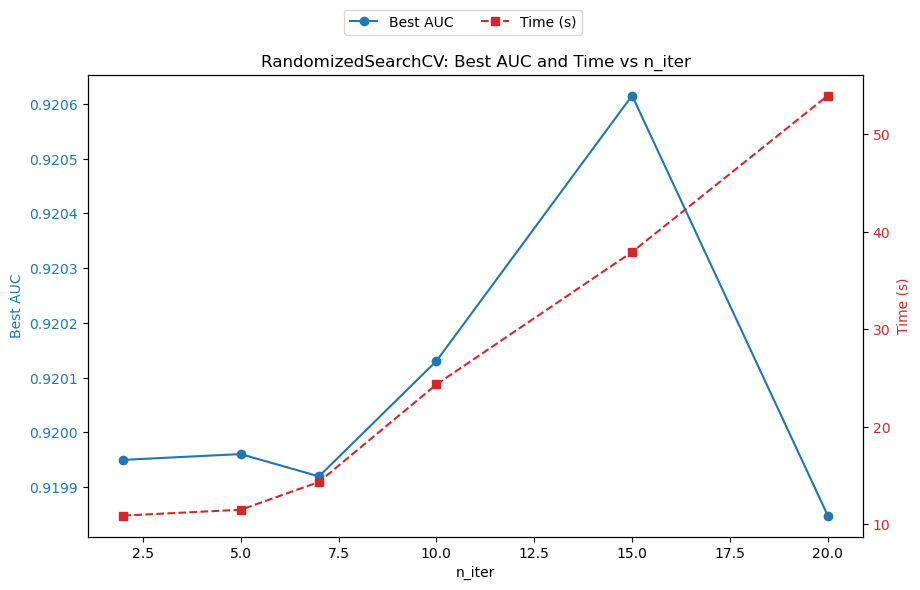

In [9]:
auc_list, time_list, params, estimators, cv_results = evaluate_random_search_over_n_iter()

In [44]:
def xgb_performance(estimators):
    """
    评估 XGBoost 模型的性能
    """
    evaluation = Evaluation()
    train_accuracy_list = []
    test_accuracy_list = []
    total_accuracy_list = []
    for i, estimator in enumerate(estimators):
        print(f"=== XGBoost Model {i+1} Evaluation ===")
        classifier = Classifier(model=estimator, random_state=42)
        classifier.load_and_preprocess_data('raw')
        train, test, total = evaluation.evaluate_model(
            classifier.model,
            classifier.train_x,
            classifier.train_y,
            classifier.test_x,
            classifier.test_y
        )
        train_accuracy_list.append(train)
        test_accuracy_list.append(test)
        total_accuracy_list.append(total)

        n_models = len(train_accuracy_list)
    df = pd.DataFrame({
        "Model #": [f"#{i+1}" for i in range(n_models)],
        "Train": train_accuracy_list,
        "Test":  test_accuracy_list,
        "Total": total_accuracy_list
    })

   # 绘图
    fig, ax = plt.subplots(figsize=(8, 5))
    bar_width = 0.25
    indices = range(n_models)

    ax.bar([i - bar_width for i in indices],
           df["Train"], width=bar_width, label="Train")
    ax.bar(indices,
           df["Test"],  width=bar_width, label="Test")
    ax.bar([i + bar_width for i in indices],
           df["Total"], width=bar_width, label="Total")

    ax.set_xticks(indices)
    ax.set_xticklabels(df["Model #"])
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("XGBoost Model")
    ax.set_title("XGBoost Models Accuracy Comparison")
    # 只显示 0.75 到 1 之间的 y 轴刻度
    ax.set_ylim(0.8, 0.9)
    ax.set_yticks(np.linspace(0.8, 0.9, 11))
    ax.legend()
    plt.tight_layout()

    plt.show()

=== XGBoost Model 1 Evaluation ===
Train Accuracy: 0.8711
Test Accuracy: 0.8644
=== XGBoost Model 2 Evaluation ===
Train Accuracy: 0.8711
Test Accuracy: 0.8658
=== XGBoost Model 3 Evaluation ===
Train Accuracy: 0.8698
Test Accuracy: 0.8645
=== XGBoost Model 4 Evaluation ===
Train Accuracy: 0.8717
Test Accuracy: 0.8651
=== XGBoost Model 5 Evaluation ===
Train Accuracy: 0.8714
Test Accuracy: 0.8640
=== XGBoost Model 6 Evaluation ===
Train Accuracy: 0.8703
Test Accuracy: 0.8639


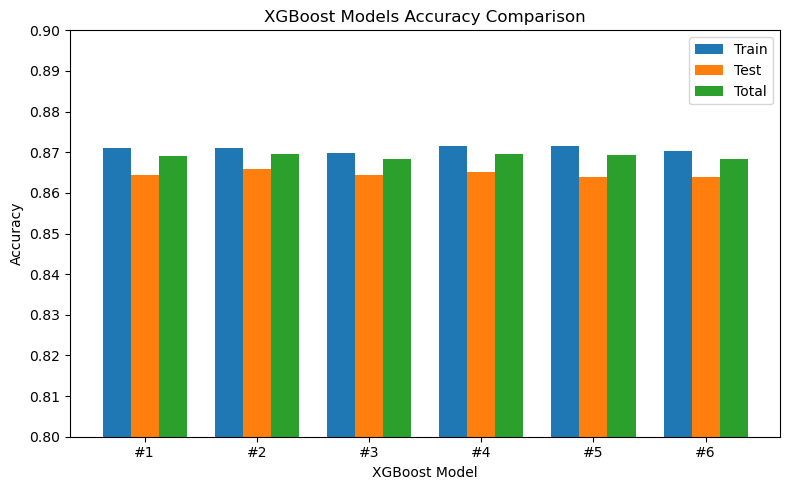

In [45]:
xgb_performance(estimators)